# HAMR 2018

## Initial Stuff

Imports

In [1]:
import os

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import librosa
from IPython.display import HTML, Video

from utils import freq_to_pitch

%matplotlib inline

Paths:

In [2]:
fn_freq_midi = os.path.join('output', 'aintMisbehavin_freq_midi.csv')
fn_freq_pyin = os.path.join('output', 'aintMisbehavin_freq_throatMic_pYIN.csv')
fn_freq_dgm = os.path.join('output', 'aintMisbehavin_freq_throatMic_DGM.csv')
fn_wav = os.path.join('data', 'throat_mic_mono.wav')
fn_startend_midi = os.path.join('output', 'aintMisbehavin_startend_midi.csv')

SAMPLERATE = 86.1328125

Reading CSVs:

In [3]:
df_midi = pd.read_csv(fn_freq_midi)
df_pyin = pd.read_csv(fn_freq_pyin)
df_dgm = pd.read_csv(fn_freq_dgm)
df_startend = pd.read_csv(fn_startend_midi)

Reading WAV and get voiced frames by simple energy threshold:

In [4]:
y, sr = librosa.load(fn_wav, sr=None)
rmse = librosa.feature.rmse(y=y, hop_length=256, frame_length=512, center=True).ravel()
threshold = 0.005
voiced = rmse > threshold

Set invalid frequency values to nan and intepolate all to same time axis

In [5]:
time = df_midi['time']
freq_midi = df_midi['freq']
freq_pyin = df_pyin['freq']
freq_dgm = df_dgm['freq']

voiced_midi = freq_midi != 0.0
freq_midi[np.logical_not(voiced_midi)] = np.nan
freq_pyin[np.logical_not(voiced)] = np.nan
freq_dgm[np.logical_not(voiced)] = np.nan

freq_pyin = interp1d(df_pyin['time'], freq_pyin, 'nearest', fill_value='extrapolate')(time)
freq_dgm = interp1d(df_dgm['time'], freq_dgm, 'nearest', fill_value='extrapolate')(time)
voiced = np.bool8(interp1d(df_dgm['time'], voiced, 'nearest', fill_value='extrapolate')(time))

Convert to midi pitch

In [6]:
pitch_midi = np.repeat(np.nan, len(freq_midi))
pitch_pyin = np.repeat(np.nan, len(freq_pyin))
pitch_dgm = np.repeat(np.nan, len(freq_dgm))

pitch_midi[voiced_midi] = freq_to_pitch(freq_midi[voiced_midi])
pitch_pyin[voiced] = freq_to_pitch(freq_pyin[voiced])
pitch_dgm[voiced] = freq_to_pitch(freq_dgm[voiced])

/Users/fzalkow/dev/hamr2018/utils.py:9: RuntimeWarning: divide by zero encountered in log2
  return 12 * np.log2(freq / ref) + 69


## Overall MIDI / Sung Pitch Comparision

plot midi in comparision with pitch track

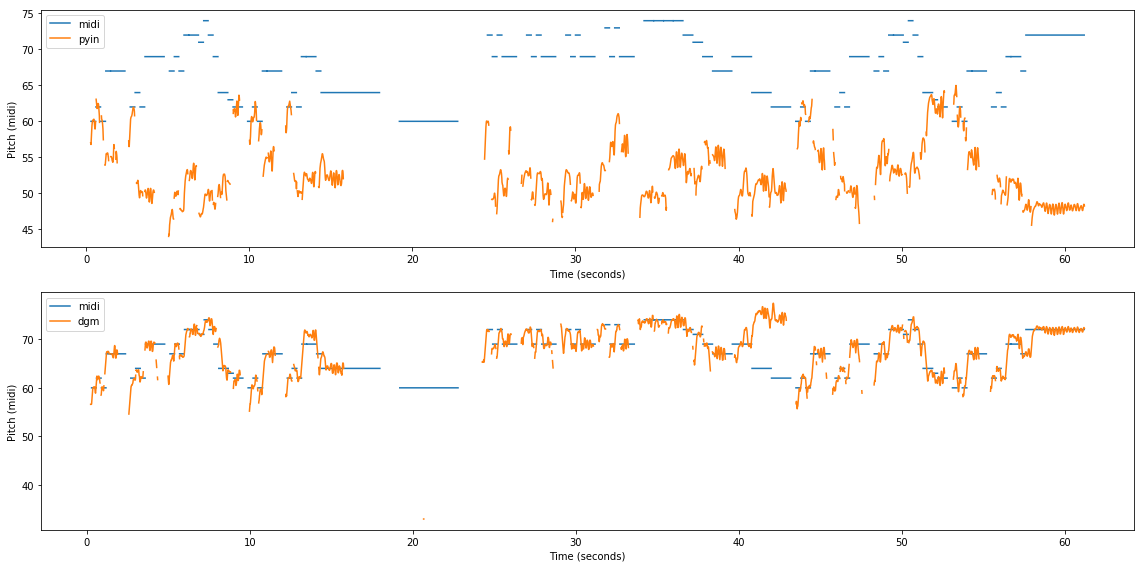

In [7]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(time, pitch_midi, label='midi')
plt.plot(time, pitch_pyin, label='pyin')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch (midi)')

plt.subplot(2, 1, 2)
plt.plot(time, pitch_midi, label='midi')
plt.plot(time, pitch_dgm, label='dgm')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch (midi)')

plt.tight_layout()

plot difference between midi and pitch tracks

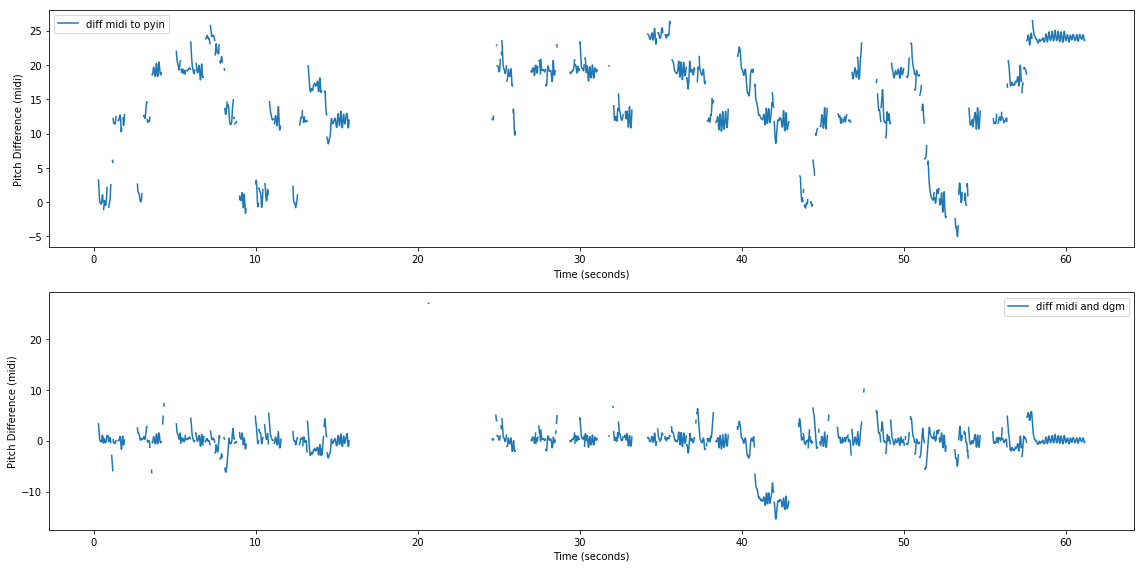

In [8]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
difference_pyin = pitch_midi - pitch_pyin
plt.plot(time, difference_pyin, label='diff midi to pyin')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch Difference (midi)')

plt.subplot(2, 1, 2)
difference_dgm = pitch_midi - pitch_dgm
plt.plot(time, difference_dgm, label='diff midi and dgm')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch Difference (midi)')

plt.tight_layout()

## Notewise Overall MIDI / Sung Pitch Comparision

Plot notes and corresponding MIDI

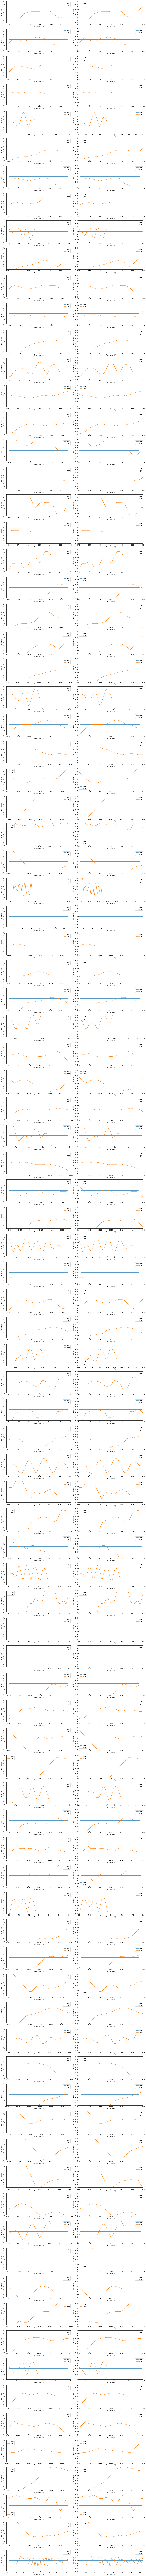

In [9]:
num_notes = len(df_startend)
plt.figure(figsize=(16, num_notes * 3))

all_midi_cut = []
all_dgm_cut = []
all_times_cut = []

for i, (start, end, pitch) in df_startend.iterrows():
    start_idx = int(np.ceil(start * SAMPLERATE))
    end_idx = int(np.floor(end * SAMPLERATE))
    
    all_times_cut.append(time[start_idx:end_idx])
    all_midi_cut.append(pitch_midi[start_idx:end_idx])
    all_dgm_cut.append(pitch_dgm[start_idx:end_idx])
    
    plt.subplot(num_notes, 2, 1 + i * 2)
    plt.plot(time[start_idx:end_idx], pitch_midi[start_idx:end_idx], label='midi')
    plt.plot(time[start_idx:end_idx], pitch_dgm[start_idx:end_idx], label='dgm')
    plt.legend()
    plt.xlabel('Time (seconds)')
    plt.ylabel('Pitch (midi)')
    plt.ylim([pitch-2, pitch+2])
    
    plt.subplot(num_notes, 2, 2 + i * 2)
    plt.plot(time, pitch_midi, label='midi')
    plt.plot(time, pitch_dgm, label='dgm')
    plt.legend()
    plt.xlabel('Time (seconds)')
    plt.ylabel('Pitch (midi)')
    plt.xlim([start, end])
    plt.ylim([pitch-2, pitch+2])
    
plt.tight_layout()

Plot centered notes and their interpolation

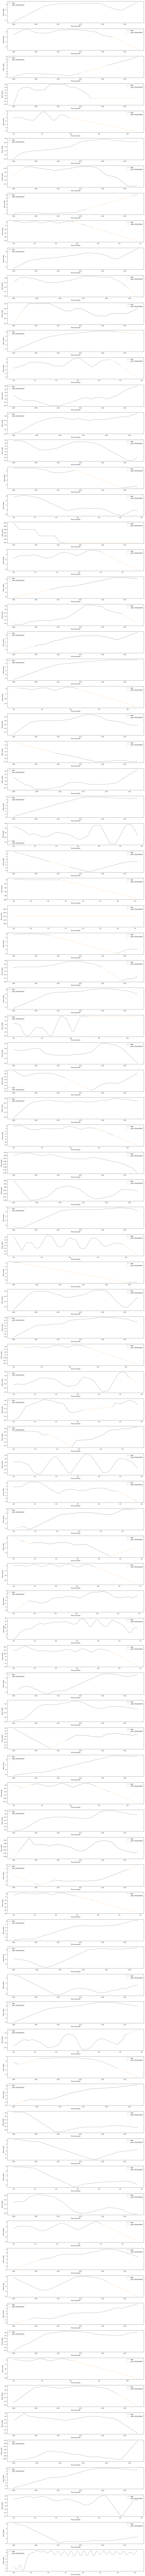

In [10]:
num_notes = len(df_startend)
plt.figure(figsize=(16, num_notes * 3))

all_notes_interpolated = []

for i, (start, end, pitch) in df_startend.iterrows():
    start_idx = int(np.ceil(start * SAMPLERATE))
    end_idx = int(np.floor(end * SAMPLERATE))
    
    note_pitch_centered = pitch_dgm[start_idx:end_idx] - pitch_midi[start_idx:end_idx]
    note_time = time.values[start_idx:end_idx]
    note_time = note_time - note_time[0]
    note_nan = np.isnan(note_pitch_centered)
    note_pitch_interpolated = interp1d(note_time[np.logical_not(note_nan)], note_pitch_centered[np.logical_not(note_nan)], 'linear', fill_value='extrapolate')(note_time)
    
    all_notes_interpolated.append(note_pitch_interpolated)
    
    plt.subplot(num_notes, 1, 1 + i)
    plt.plot(note_time, note_pitch_centered, '--', label='dgm')
    plt.plot(note_time, note_pitch_interpolated, ':', label='dgm (interpolated)')
    plt.legend()
    plt.xlabel('Time (seconds)')
    plt.ylabel('Pitch (midi)')
    
plt.tight_layout()

Plot interpolated notes and the polynomial

/Users/fzalkow/miniconda3/envs/hamr2018/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/fzalkow/miniconda3/envs/hamr2018/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/fzalkow/miniconda3/envs/hamr2018/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/fzalkow/miniconda3/envs/hamr2018/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/fzalkow/miniconda3/envs/hamr2018/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/User

(94, 7)

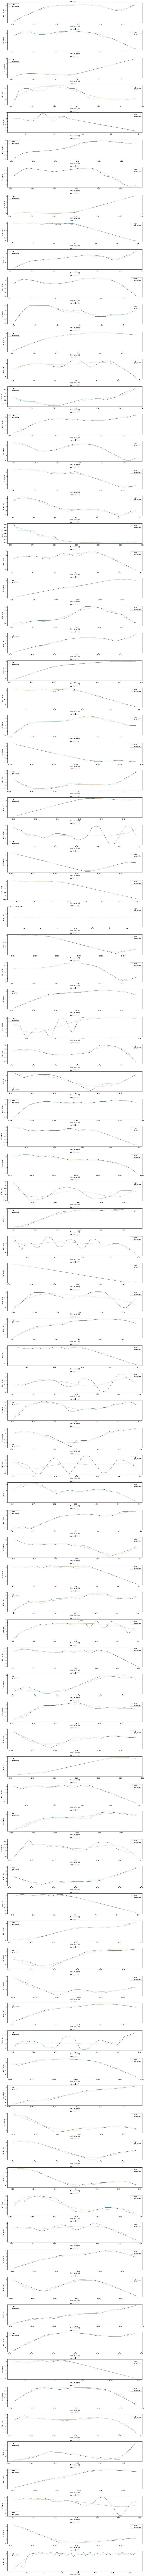

In [11]:
num_notes = len(df_startend)
plt.figure(figsize=(16, num_notes * 3))

features = []

for i, (time, note) in enumerate(zip(all_times_cut, all_notes_interpolated)):
    # features.append([note.min(),
    #                 note.max(),
    #                 np.std(note),
    #                 np.median(note)])
    poly = np.polyfit(time, note, deg=5)
    note_poly = np.poly1d(poly)(time)
    
    avg_error = np.average(np.abs(note - note_poly))
    
    feature = np.concatenate([poly, [avg_error]])
    features.append(feature)
    
    plt.subplot(num_notes, 1, 1 + i)
    
    plt.plot(time, note, '--', label='dgm')
    plt.plot(time, note_poly, ':', label='polynomial')
    plt.legend()
    plt.xlabel('Time (seconds)')
    plt.ylabel('Pitch (midi)')
    plt.title('error: %.3f' % avg_error)

plt.tight_layout()
features = np.array(features)
features.shape

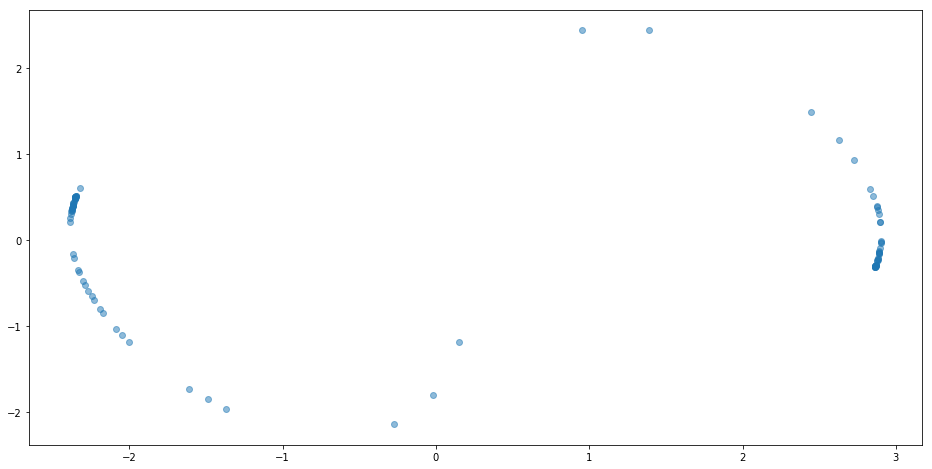

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn import preprocessing

features_scaled = features / np.abs(features).max(axis=1).reshape((features.shape[0], 1))
features_scaled = preprocessing.scale(features_scaled, axis=1)

# features_2d = MDS(n_components=2).fit_transform(features_scaled)

# features_2d = TSNE(n_components=2, perplexity=20, n_iter=10000, learning_rate=10, random_state=42).fit_transform(features)
features_2d = PCA(n_components=2).fit_transform(features_scaled)

plt.figure(figsize=(16, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.5)

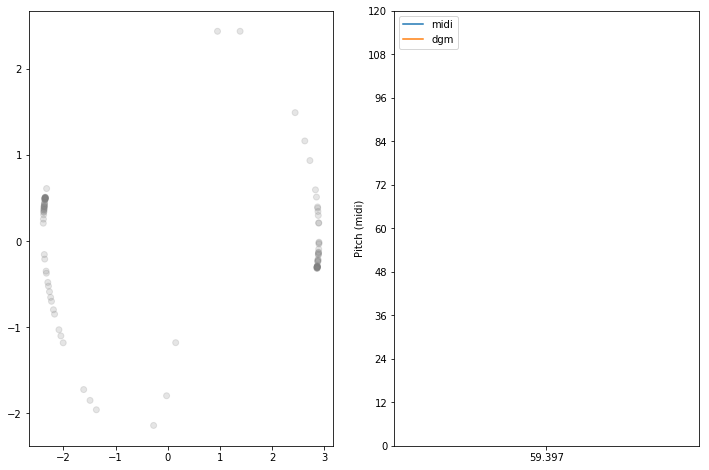

In [35]:
# note number per frame
midi_start = df_startend['start'].values
midi_end = df_startend['end'].values
frames_time = df_dgm['time'].values
num_frames = len(frames_time)

note_number = np.repeat(np.nan, num_frames)

for i, frame_time in enumerate(frames_time):
    mask = np.logical_and(frame_time >= midi_start, frame_time < midi_end)
    assert mask.sum() == 1 or mask.sum() == 0
    if mask.sum() == 1:
        note_number[i] = np.where(mask)[0][0]

# First set up the figure, the axis, and the plot element we want to animate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax2.set_xlim(( 0, 2))
ax2.set_ylim((-2, 2))
num_notes = features_2d.shape[0]

scatter = ax1.scatter(features_2d[:, 0], features_2d[:, 1])

line1, = ax2.plot([], [], label='midi')
line2, = ax2.plot([], [], label='dgm')
leg = ax2.legend(loc='upper left')
ax2.set_ylabel('Pitch (midi)')

ax2_ymin = min(np.nanmin(np.concatenate(all_midi_cut)), np.nanmin(np.concatenate(all_dgm_cut)))
ax2_ymax = max(np.nanmax(np.concatenate(all_midi_cut)), np.nanmax(np.concatenate(all_dgm_cut)))
ax2.set_ylim([ax2_ymin, ax2_ymax])
ax2.set_yticks(np.arange(0, 128, 12))
ax2.set_xticks([])
    
colors = np.tile([0.5, 0.5, 0.5, 0.2], [num_notes, 1])

# initialization function: plot the background of each frame
def init():
    scatter.set_color(colors)
    line1.set_data([], [])
    line2.set_data([], [])
    return (scatter, line1, line2)

# animation function. This is called sequentially
def animate(i):
    
    cur_note_number = note_number[i]
    if not np.isnan(cur_note_number):
        cur_note_number = int(cur_note_number)
        tmp_colors = colors.copy()
        # tmp_colors[cur_note_number] = [1, 0, 0, 1]
        tmp_colors[-1] = [1, 0, 0, 1]
        
        tmp_feat1 = features_2d[:, 0]
        tmp_feat2 = features_2d[:, 1]
        
        tmp_feat1 = np.concatenate((tmp_feat1[np.arange(len(tmp_feat1))!=cur_note_number], tmp_feat1[cur_note_number:cur_note_number+1]))
        tmp_feat2 = np.concatenate((tmp_feat2[np.arange(len(tmp_feat2))!=cur_note_number], tmp_feat2[cur_note_number:cur_note_number+1]))

        scatter.set_color(tmp_colors)
        scatter.set_offsets(np.stack([tmp_feat1, tmp_feat2], axis=1))
        
        cur_time = all_times_cut[cur_note_number]
        cur_midi = all_midi_cut[cur_note_number]
        cur_dgm = all_dgm_cut[cur_note_number]
        
        line1.set_data(cur_time, cur_midi)
        line2.set_data(cur_time, cur_dgm)
        
        ax2.set_xlim((cur_time.min(), cur_time.max()))
        
        cur_time_center = (cur_time.min() + cur_time.max()) / 2
        ax2.set_xticks([cur_time_center])
        ax2.set_xticklabels(['%06.3f' % cur_time_center])
        
    else:
        scatter.set_color(colors)
        line1.set_data([], [])
        line2.set_data([], [])
    
    return (scatter, line1, line2)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=num_frames, interval=1000/SAMPLERATE, blit=True)

HTML(anim.to_html5_video())

In [36]:
fn_scatter_noaudio = os.path.join('output', 'scatter_noaudio.mp4')
fn_scatter = os.path.join('output', 'scatter.mp4')
fn_audio = os.path.join('data', 'throat_mic_mono.wav')

anim.save(fn_scatter_noaudio)
os.system('ffmpeg -i {} -i {} -vcodec copy {}'.format(fn_scatter_noaudio, fn_audio, fn_scatter))

0

In [37]:
Video(fn_scatter)